#Analyze Spotify Genre
##In this notebook, I fed the data into a multi-class classification algorithm to try to predict the genre of a song based on the audible attributes. For the purpose of limiting the genres to classify, I went with songs within just the top 7 most popular genres according to the genre analysis done in previous secitons. With some optimizations and a little leeway, the algorithm was able to predict a songs genre with about 68% accuracy in 1 prediction and with about 84% accuracy with 2 predictions. I was fairly satisfied with this result given the difficulty of 7-way classification.

## Data Preprocessing:

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from google.colab import files
uploaded = files.upload()

Saving cleaned_tracks_both.csv to cleaned_tracks_both.csv


In [2]:
track_table = pd.read_csv("cleaned_tracks_both.csv")
track_table.dropna(inplace=True)

A quick reminder about the number of tracks per genre:

In [3]:
track_table.groupby("master_popular_genre").track_id.count()

master_popular_genre
country    10005
hiphop     10728
house       6529
indie       7673
pop        17277
r&b         5505
rock        8967
Name: track_id, dtype: int64

In [4]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
data_numerics = pd.concat([track_table.select_dtypes(include=[np.number]),track_table['master_popular_genre']],axis=1, sort=False)

One more look at the data:

In [5]:
track_table_dummies = pd.get_dummies(data_numerics,columns=['key','time_signature',],drop_first=True)
track_table_dummies = track_table_dummies.drop('loudness', axis=1)
track_table_dummies.head()

,track_pop,track_year,duration_ms,energy,speechiness,acousticness,mode,tempo,valence,danceability,instrumentalness,liveness,master_popular_genre,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,50,2011,247010,0.41200,0.0357,0.94300,1,88.113,0.193,0.167,0.000121,0.7570,pop,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,44,2011,353667,0.72700,0.0462,0.03010,0,87.349,0.391,0.485,0.758000,0.1630,rock,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,37,2011,163000,0.00385,0.0449,0.99500,0,141.201,0.117,0.228,0.917000,0.0858,rock,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,41,2011,253991,0.30500,0.0318,0.93600,1,85.786,0.446,0.230,0.000002,0.7440,pop,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,42,2011,294613,0.95400,0.0607,0.00894,0,163.995,0.287,0.454,0.000000,0.0659,rock,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [6]:
#move genre to front
genre = track_table_dummies['master_popular_genre']
track_table_dummies.drop('master_popular_genre', axis=1,inplace = True)
track_table_dummies.insert(0, 'master_popular_genre', genre)

In [7]:
track_table_dummies.head()

,master_popular_genre,track_pop,track_year,duration_ms,energy,speechiness,acousticness,mode,tempo,valence,danceability,instrumentalness,liveness,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,time_signature_1,time_signature_3,time_signature_4,time_signature_5
0,pop,50,2011,247010,0.41200,0.0357,0.94300,1,88.113,0.193,0.167,0.000121,0.7570,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0
1,rock,44,2011,353667,0.72700,0.0462,0.03010,0,87.349,0.391,0.485,0.758000,0.1630,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0
2,rock,37,2011,163000,0.00385,0.0449,0.99500,0,141.201,0.117,0.228,0.917000,0.0858,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
3,pop,41,2011,253991,0.30500,0.0318,0.93600,1,85.786,0.446,0.230,0.000002,0.7440,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,rock,42,2011,294613,0.95400,0.0607,0.00894,0,163.995,0.287,0.454,0.000000,0.0659,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0


In [8]:
X = track_table_dummies.iloc[:,1:]
y = track_table_dummies.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

Here are the 7 possible genre classifications:

In [9]:
print("Genres:",y_train.unique())

Genres: ['house' 'pop' 'hiphop' 'r&b' 'country' 'rock' 'indie']


## Training the model:
Piggybacking off the success of the Gradient Boost from the previous exploration, I chose to try a Gradient Boost classifier first for the multi-class classification. I chose not to vary a ton of parameters here, as it took 5-10 minutes per iteration. With cross-validation and a grid search of 3-4 different variables, this optimization takes hours.

In [10]:
from sklearn.ensemble import GradientBoostingClassifier

In [11]:
gb_param_grid = {
       #'n_estimators': range(350, 700, 100),
       'n_estimators': [650],
       #'max_depth':range(3,8),
       'max_depth':[6],
       #'learning_rate' : [0.1,0.3],
       'learning_rate' : [0.1],
       #'min_samples_split': [0.05, 0.1]
       'min_samples_split': [0.05]

}
#grid = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=3, verbose=2).fit(X_train, y_train)
grid = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=2, verbose=2).fit(X_train, y_train)


# summarize the results of the grid search
print("The best score is {}".format(grid.best_score_))
print("The best hyper parameter setting is {}".format(grid.best_params_))
print("Model Accuracy:", accuracy_score(y_test,grid.predict(X_test)))

Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650, total=10.9min
[CV] learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 10.9min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650, total=10.8min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 21.7min finished


The best score is 0.5811808943999284
The best hyper parameter setting is {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_split': 0.05, 'n_estimators': 650}
Model Accuracy: 0.592883758974825


In [12]:
def print_accuracy(genre_index):
  print("Accuracy predicting", genre_order[genre_index], ":", conf_matrix[genre_index,genre_index]/(sum(conf_matrix[genre_index,:])))

Accuracy predicting country : 0.7239927841250752
Accuracy predicting hiphop : 0.6996537795729948
Accuracy predicting house : 0.6511305952930319
Accuracy predicting indie : 0.49236058059587473
Accuracy predicting pop : 0.5746439247406365
Accuracy predicting r&b : 0.4085603112840467
Accuracy predicting rock : 0.5134216785592932


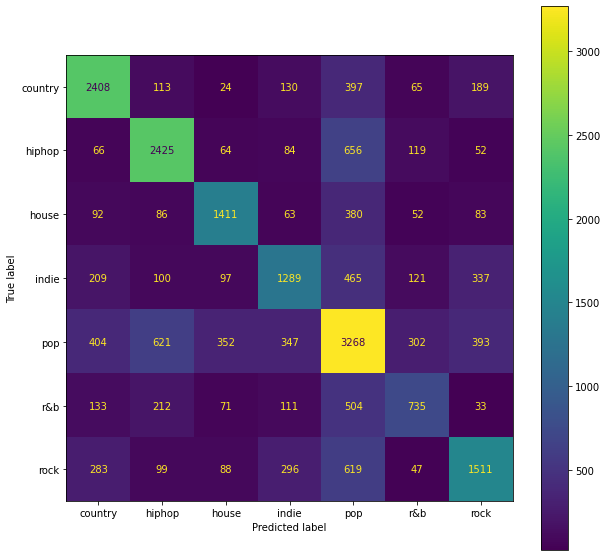

In [13]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
genre_order = ['country', 'hiphop', 'house', 'indie', 'pop', 'r&b', 'rock']

conf_matrix = confusion_matrix(y_test, grid.predict(X_test), labels=genre_order)
fig, ax = plt.subplots(figsize=(10, 10))
print(plot_confusion_matrix(X=X_test,y_true=y_test, labels=genre_order,estimator=grid, ax=ax,values_format = 'd'))
for i in range(0,len(genre_order)):
  print_accuracy(i)
#print("Accuracy predicting Country:", conf_matrix[0,0]/(sum(conf_matrix[0,:])))
#print("Accuracy predicting HipHop:", conf_matrix[1,1]/(sum(conf_matrix[1,:])))
#print("Accuracy predicting House:", conf_matrix[2,2]/(sum(conf_matrix[2,:])))
#print("Accuracy predicting Indie:", conf_matrix[3,3]/(sum(conf_matrix[3,:])))
#print("Accuracy predicting Pop:", conf_matrix[4,4]/(sum(conf_matrix[4,:])))
#print("Accuracy predicting R&B:", conf_matrix[5,5]/(sum(conf_matrix[5,:])))
#print("Accuracy predicting Rock:", conf_matrix[6,6]/(sum(conf_matrix[6,:])))

In [14]:
array= conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
type(array)
#sns.heatmap(array)

numpy.ndarray

Text(0.5, 1.0, 'Proportional Genre Confusion Matrix')

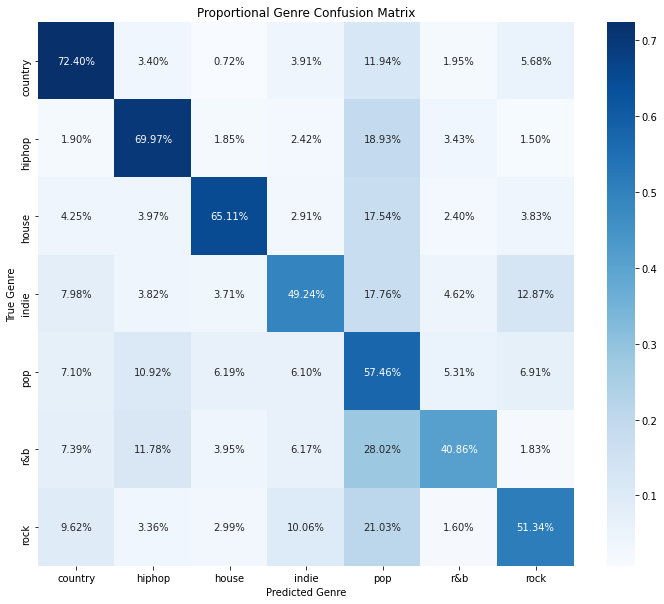

In [16]:
fig, ax = plt.subplots(figsize=(12,10)) 

sns.heatmap(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], annot=True,fmt='.2%', cmap='Blues',xticklabels=genre_order,yticklabels=genre_order, ax=ax)
ax.set(xlabel='Predicted Genre', ylabel='True Genre')
ax.set_title("Proportional Genre Confusion Matrix")

In [ ]:
for count,genre_preds in enumerate(conf_matrix):
  print("True Genre:", genre_order[count])
  genre_preds[list(genre_preds).index(max(genre_preds))] = 0
  incorrect_guess = genre_order[list(genre_preds).index(max(genre_preds))]
  print("Most Common Incorrect Prediction:", incorrect_guess)
  print("Percent of All Incorrect Predictions as", incorrect_guess, (max(genre_preds) / sum(genre_preds)))
  print()

In [59]:
# Add prediction of 2nd highest probability genre
two_preds = []
for prediction in grid.predict_proba(X_test):
  prediction = list(prediction)
  two_maxes = []
  two_maxes.append(prediction.index(max(prediction)))
  prediction[prediction.index(max(prediction))] = 0
  two_maxes.append(prediction.index(max(prediction)))
  two_preds.append(two_maxes)

In [60]:
# Convert probability to genre name
for pred in two_preds:
  pred[0] = genre_order[pred[0]]
  pred[1] = genre_order[pred[1]]

In [61]:
# Create list to evaluate accuracy
in_list = []
for i in range(0,len(two_preds)):
  in_list.append(int(list(y_test)[i] in two_preds[i]))

In [62]:
print("Accuracy:" , sum(in_list) / len(in_list))

Accuracy: 0.8414017650586925


In [22]:
pred_correctly = []
true_genre = []
predicted_genre = []

for i in range(0,len(y_test)):
  pred_correctly.append(in_list[i])
  true_genre.append(list(y_test)[i])
  predicted_genre.append(two_preds[i])

prediction_frame = pd.DataFrame({"Predicted_Correctly":pred_correctly,
                                 "True Genre": true_genre,
                                 "Predicted Genres": predicted_genre,
                                 "Track Name": track_table.track_name[y_test.index],
                                 "Artist Name": track_table.art_name[y_test.index]})

In [23]:
display(prediction_frame[prediction_frame.Predicted_Correctly == 0])

,Predicted_Correctly,True Genre,Predicted Genres,Track Name,Artist Name
2885,0,country,"[hiphop, pop]",Smoke Stack,The Lacs
52843,0,hiphop,"[house, country]",Tattoo,Kevin Abstract
34983,0,pop,"[rock, country]",Start A Riot,BANNERS
65658,0,rock,"[country, pop]",Midnight Thoughts,Set It Off
57048,0,r&b,"[pop, hiphop]",Dingo X BIBI - she got it,BIBI
...,...,...,...,...,...
32184,0,pop,"[rock, country]",Breathless,Small Black
7861,0,country,"[pop, r&b]",Mother,Sugarland
19231,0,hiphop,"[pop, rock]",I've Been Waiting (feat. ILOVEMAKONNEN) - Orig...,Lil Peep
9693,0,country,"[pop, r&b]",A ROCK,HARDY


Rebalance dataset, try again:

In [24]:
from sklearn.utils import resample

In [38]:
df_nonpop = track_table_dummies[track_table_dummies['master_popular_genre']!='pop']
df_pop = track_table_dummies[track_table_dummies['master_popular_genre']=='pop']
samp = 10000
# Downsample majority class
df_pop_downsampled = resample(df_pop, 
                                 replace=False,    # sample without replacement
                                 n_samples=10000) # reproducible results
 
# Combine minority class with downsampled majority class
df_pop_downsampled = pd.concat([df_pop_downsampled, df_nonpop])
 
# Display new class counts
df_pop_downsampled.master_popular_genre.value_counts()

hiphop     10728
country    10005
pop        10000
rock        8967
indie       7673
house       6529
r&b         5505
Name: master_popular_genre, dtype: int64

In [26]:
X = df_pop_downsampled.iloc[:,1:]
y = df_pop_downsampled.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [27]:
gb_param_grid = {
       #'n_estimators': range(350, 700, 100),
       'n_estimators': [650],
       #'max_depth':range(3,8),
       'max_depth':[6],
       #'learning_rate' : [0.1,0.3],
       'learning_rate' : [0.1],
       #'min_samples_split': [0.05, 0.1]
       'min_samples_split': [0.05]

}
#grid = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=3, verbose=2).fit(X_train, y_train)
grid = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=3, verbose=2).fit(X_train, y_train)


# summarize the results of the grid search
print("The best score is {}".format(grid.best_score_))
print("The best hyper parameter setting is {}".format(grid.best_params_))
print("Model Accuracy:", accuracy_score(y_test,grid.predict(X_test)))


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650, total=12.4min
[CV] learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 12.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650, total=12.4min
[CV] learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650 
[CV]  learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650, total=12.4min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 37.3min finished


The best score is 0.6124705455863694
The best hyper parameter setting is {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_split': 0.05, 'n_estimators': 650}
Model Accuracy: 0.6146567132793608


Text(0.5, 1.0, 'Proportional Genre Confusion Matrix')

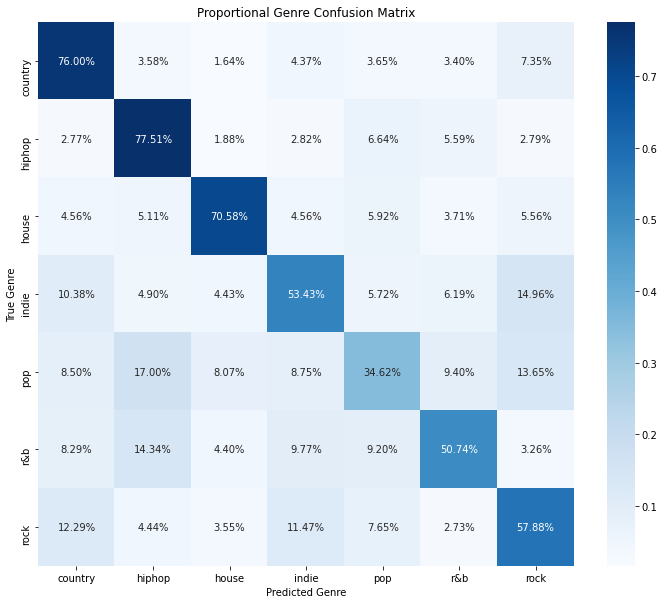

In [30]:
fig, ax = plt.subplots(figsize=(12,10)) 
conf_matrix = confusion_matrix(y_test, grid.predict(X_test), labels=genre_order)
sns.heatmap(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], annot=True,fmt='.2%', cmap='Blues',xticklabels=genre_order,yticklabels=genre_order, ax=ax)
ax.set(xlabel='Predicted Genre', ylabel='True Genre')
ax.set_title("Proportional Genre Confusion Matrix")

Oversampling

In [50]:
def oversample(genre, numTracks):
  df = df_pop_downsampled[df_pop_downsampled['master_popular_genre']==genre]
  df_upsampled = resample(df, replace=True, n_samples=numTracks)
  return df_upsampled

In [51]:
df_rb = oversample("r&b", samp)
df_house = oversample("house", samp)
df_indie = oversample("indie", samp)
df_rock = oversample("rock", samp)

df_rest = df_pop_downsampled[df_pop_downsampled['master_popular_genre']!='r&b']
df_rest = df_rest[df_rest['master_popular_genre']!='house']
df_rest = df_rest[df_rest['master_popular_genre']!='indie']
df_rest = df_rest[df_rest['master_popular_genre']!='rock']

# Combine minority class with downsampled majority class
df_balanced = pd.concat([df_rest, df_rb, df_house, df_indie, df_rock])
 
# Display new class counts
df_balanced.master_popular_genre.value_counts()

hiphop     10728
country    10005
house      10000
rock       10000
r&b        10000
pop        10000
indie      10000
Name: master_popular_genre, dtype: int64

In [53]:
X = df_balanced.iloc[:,1:]
y = df_balanced.iloc[:,0]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [54]:
gb_param_grid = {
       #'n_estimators': range(350, 700, 100),
       'n_estimators': [650],
       #'max_depth':range(3,8),
       'max_depth':[6],
       #'learning_rate' : [0.1,0.3],
       'learning_rate' : [0.1],
       #'min_samples_split': [0.05, 0.1]
       'min_samples_split': [0.05]

}
#grid = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=3, verbose=2).fit(X_train, y_train)
grid = GridSearchCV(GradientBoostingClassifier(), gb_param_grid, cv=2, verbose=2).fit(X_train, y_train)


# summarize the results of the grid search
print("The best score is {}".format(grid.best_score_))
print("The best hyper parameter setting is {}".format(grid.best_params_))
print("Model Accuracy:", accuracy_score(y_test,grid.predict(X_test)))


Fitting 2 folds for each of 1 candidates, totalling 2 fits
[CV] learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650 


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650, total=11.4min
[CV] learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed: 11.4min remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=6, min_samples_split=0.05, n_estimators=650, total=11.4min


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed: 22.8min finished


The best score is 0.6625941597364892
The best hyper parameter setting is {'learning_rate': 0.1, 'max_depth': 6, 'min_samples_split': 0.05, 'n_estimators': 650}
Model Accuracy: 0.6834033073429869


In [57]:
for i in range(0,len(genre_order)):
  print_accuracy(i)

Accuracy predicting country : 0.7418963950318086
Accuracy predicting hiphop : 0.7544209925841415
Accuracy predicting house : 0.8343014368694589
Accuracy predicting indie : 0.6718417047184171
Accuracy predicting pop : 0.374885145482389
Accuracy predicting r&b : 0.7587835842928845
Accuracy predicting rock : 0.6396152690111211


Text(0.5, 1.0, 'Proportional Genre Confusion Matrix')

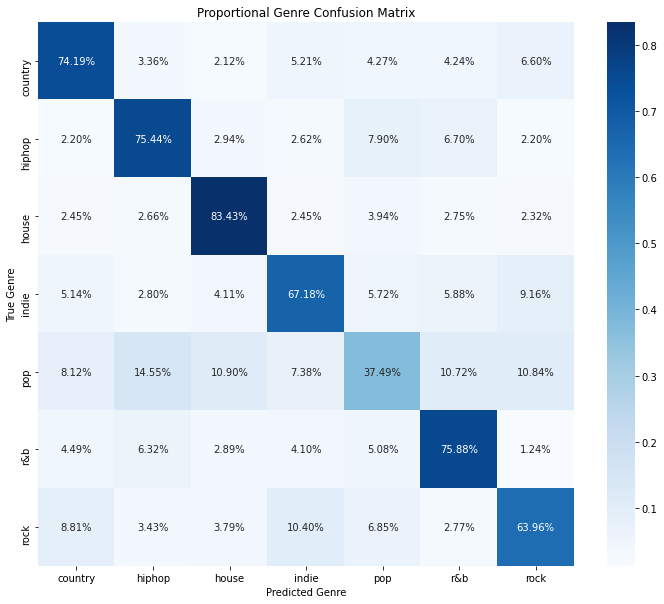

In [56]:
fig, ax = plt.subplots(figsize=(12,10)) 
conf_matrix = confusion_matrix(y_test, grid.predict(X_test), labels=genre_order)
sns.heatmap(conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis], annot=True,fmt='.2%', cmap='Blues',xticklabels=genre_order,yticklabels=genre_order, ax=ax)
ax.set(xlabel='Predicted Genre', ylabel='True Genre')
ax.set_title("Proportional Genre Confusion Matrix")

Tried PCA, didn't work:

In [28]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

track_table_clusters = track_table_dummies.drop('master_popular_genre', axis=1)
scaler = StandardScaler()
track_table_clusters[track_table_clusters.columns] = scaler.fit_transform(track_table_clusters[track_table_clusters.columns])

Text(0, 0.5, 'cumulative explained variance')

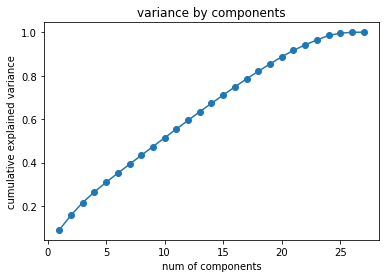

In [29]:
pca = PCA()
pca.fit(track_table_clusters)
plt.plot(range(1,28), pca.explained_variance_ratio_.cumsum(), marker='o')
plt.title('variance by components')
plt.xlabel('num of components')
plt.ylabel('cumulative explained variance')

TODO:
Test with JUST oversampling, leave pop the same
Clean up multiple sampling changes
Compare the 3 models
What tracks is it most confident in? Essence of hip hop, pop, house, etc